In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import forward


from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model


## Translated forward model from matlab files

In [2]:
# Layout -------L-------
#           ---l---
## A        M       N       B
#  ---r1--
#          --------r2-------
#  --------r3-------
#                    ---r4--

In [3]:
# Setup starting model and initial guess
params=[200, 500, 300, 100, 1, 3, 2]
b_0 = [250, 490, 250, 200, 1.5, 4, 1]

# Make your measurements
number_of_measurements=100
L = np.logspace(0.1, 3, number_of_measurements) 
l = 0.01*L 

#Schlumberger Geometry 
r1 = L-l  
r2 = L+l  
r3 = L+l   
r4 = L-l  

# Get the simulated data
rho_semu = forward.ves_forward(params, L)

# SimPeg Forward Model

## Forward Simulation - Example from generated data from matlab code

In [4]:
# Define the 'a' spacing for Schlumberger array measurements for each reading
number_of_measurements=100
a_b_electrode_separations = np.logspace(0.1, 3, number_of_measurements)
m_n_electrode_separations = 0.01 * a_b_electrode_separations 

# AB Half electrode spacing
half_electrode_spacing= [250, 490, 250, 200, 1.5, 4, 1]


source_list = []  # create empty array for sources to live

for ab, mn in zip(a_b_electrode_separations, m_n_electrode_separations):


    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-ab, 0.0, 0.0]
    B_location = np.r_[ab, 0.0, 0.0]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-mn, 0.0, 0.0]
    N_location = np.r_[mn, 0.0, 0.0]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

In [5]:
# Define layer thicknesses.
layer_thicknesses = np.r_[1, 3, 2]

# Define layer resistivities.
model = np.r_[200, 500, 300, 100]

# Define mapping from model to 1D layers.
model_map = maps.IdentityMap(nP=len(model))

In [6]:
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

# Predict data for a given model
dpred = simulation.dpred(model)


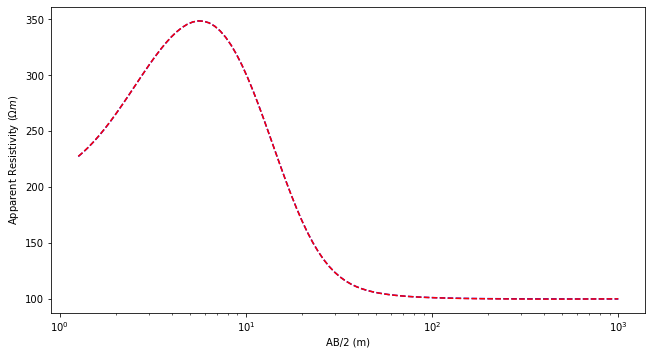

In [7]:

# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax1.plot(a_b_electrode_separations, dpred, "b--")
ax1.plot(a_b_electrode_separations, rho_semu, "r--")
ax1.plot()
ax1.set_xscale('log')
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.show()
